# ITCS 4152/5152 Assignment3-Part1
**Due date: 11:59 pm EST on Nov 16, 2022 (Wed.)**

---
In this semester, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your UNC Charlotte (*.uncc.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

Settings used for assignments: ***Edit -> Notebook Settings -> Runtime Type (Python 3)***.


## Description
---
This project is an introduction to deep learning tools for computer vision. You will design and train deep convolutional networks for scene recognition using [PyTorch](http://pytorch.org). You can visualize the
structure of the network with [mNeuron] (http://vision03.csail.mit.edu/cnn_art/index.html)

In the previous you have trained a deep convolutional network from scratch to recognize scenes. The starter codes similar to the previous assignment gives you methods to load data and display them. In the previous assignment you might have managed to achieve a recognition accuracy to 50, 60, or perhaps 70%. Unfortunately, we only have 2,400 training examples so it doesn't seem possible to train a network from scratch which outperforms hand-crafted features

Therefore, in this assignment, you will instead fine-tune a pre-trained deep network to achieve about 85% accuracy on the task. We will use the pretrained AlexNet network which was not trained to recognize scenes at all.

This approach and the previous approach of training from the scratch represent the most common approaches to recognition problems in computer vision today -- train a deep network from scratch if you have enough data (it's not always obvious whether or not you do), and if you cannot then instead fine-tune a pre-trained network.

There are 3 sub problems (under Problem 1) in this homework with a total of 70 points and 10 bonus points. Be sure to read **Submission Guidelines** below. They are important. For the problems requiring text descriptions, you might want to add a markdown block for that. **Note that the instructor and the TAs are not going to provide any further information regarding the bonus question**.

## Dataset
---
Save the [dataset(click me)](https://drive.google.com/open?id=1NWC3TMsXSWN2TeoYMCjhf2N1b-WRDh-M) into your working folder in your Google Drive for this homework. <br>
Under your root folder, there should be a folder named "data" (i.e. XXX/Surname_Givenname_UNCCID/data) containing the images.
**Do not upload** the data subfolder before submitting on blackboard due to size limit. There should be only one .ipynb file under your root folder Surname_Givenname_UNCCID.

## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation).
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before doing your homework.
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.

In [2]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 
import time

import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from sklearn import svm

In [3]:
# Mount your google drive where you've saved your assignment folder
%cd 4152 Building Pictures/new_data

e:\Group2CompVisProject\4152 Building Pictures\new_data


## Problem 0: Loading and Preprocessing data
---
(0 point) In this part, you are provided with a function that loads data into minibatches for training and testing in PyTorch. However, some preprocessing parts are missing. Your will need to implement them when doing Problem 1.

In [5]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------

def set_random_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
set_random_seed(0)

class_names = [name[8:] for name in glob.glob('./train/*')]
class_names = dict(zip(range(len(class_names)), class_names))
print("class_names: %s " % class_names)

def load_dataset(path, img_size, num_per_class=-1, batch_size=16, shuffle=False,
           augment=False, is_color=False, zero_centered=False):    
    data = []
    labels = []    
    channel_num = 3 if is_color else 1
        
    # read images and resizing
    for id, class_name in class_names.items():
        print("Loading images from class: %s" % id)
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            if is_color:
                img = cv2.imread(filename)
            else:
                img = cv2.imread(filename, 0)
            
            # resize the image
            img = cv2.resize(img, img_size, cv2.INTER_LINEAR)
            
            if is_color:
                img = np.transpose(img, [2, 0, 1])
            
            # norm pixel values to [-1, 1]
            data.append(img.astype(np.float)/255*2-1)
            
    ##########--WRITE YOUR CODE HERE--##########
    # Data Augmentation 
    if augment: 
        
        
      augment = []

      for img in data:
        img_flip = np.fliplr(img)
        augment.append(img_flip)

      data = data + augment  
      labels = labels + labels




    ##########-------END OF CODE-------##########    
    
    ##########--WRITE YOUR CODE HERE--##########
    # Data Normalization
    if zero_centered:
        
      mean = np.mean(data, axis=0)
      for idx, img in enumerate(data):
        data[idx] = img - mean



        
    ##########-------END OF CODE-------##########
         
    # randomly permute (this step is important for training)
    if shuffle:
        bundle = list(zip(data, labels))
        random.shuffle(bundle)
        data, labels = zip(*bundle)
    
    # divide data into minibatches of TorchTensors
    if batch_size > 1:
        batch_data = []
        batch_labels = []
        
         
        for i in range(int(len(data) / batch_size)):
            minibatch_d = data[i*batch_size: (i+1)*batch_size]
            minibatch_d = np.reshape(minibatch_d, (batch_size, channel_num, img_size[0], img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))

            minibatch_l = labels[i*batch_size: (i+1)*batch_size]
            batch_labels.append(torch.LongTensor(minibatch_l))
           
        
        data, labels = batch_data, batch_labels 
    
    return zip(batch_data, batch_labels)

class_names: {0: '12 - Smith', 1: '17 - Belk Gym', 2: '32 - Colvard', 3: '34 - Prospector', 4: '38 - Burson', 5: '4 - Atkins', 6: '46 - SAC', 7: '52 - Cato', 8: '56 - Woodward', 9: '63 - CHHS', 10: '69 - Student Union', 11: '96 - UREC'} 


In [6]:
# load data into size (64, 64)
img_size = (64, 64)
batch_size = 64 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./train/', img_size, batch_size=batch_size, shuffle=True, augment=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./val/', img_size, num_per_class=50, batch_size=batch_size))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Finish loading 68 minibatches (batch_size=64) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Finish loading 5 minibatches (batch_size=64) of testing samples.


4 - Atkins


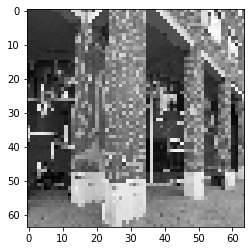

In [8]:
# show some images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if len(npimg.shape) > 2:
        npimg = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(npimg, 'gray')
    plt.show()
img, label = trainloader_small[0][0][15][0], trainloader_small[0][1][15]
label = int(np.array(label))
print(class_names[label])
imshow(img)

## Problem 1: Fine Tuning a Pre-Trained Deep Network
Our convolutional network to this point isn't "deep". Fortunately, the representations learned by deep convolutional networks is that they generalize surprisingly well to other recognition tasks. 

But how do we use an existing deep network for a new recognition task? Take for instance,  [AlexNet](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks) network has 1000 units in the final layer corresponding to 1000 ImageNet categories.


**Hints**:
- Many pre-trained models are available in PyTorch at [here](http://pytorch.org/docs/master/torchvision/models.html).
- For fine-tuning pretrained network using PyTorch, please read this [tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

### Problem 1.1

**Strategy A**: *Fine-tune* an existing network. In this scenario you take an existing network, replace the final layer (or more) with random weights, and train the entire network again with images and ground truth labels for your recognition task. You are effectively treating the pre-trained deep network as a better initialization than the random weights used when training from scratch. When you don't have enough training data to train a complex network from scratch (e.g. with the 16 classes) this is an attractive option. Fine-tuning can work far better than Strategy B of taking the activations directly from an pre-trained CNN. For example, in [this paper](http://www.cc.gatech.edu/~hays/papers/deep_geo.pdf) from CVPR 2015, there wasn't enough data to train a deep network from scratch, but fine tuning led to 4 times higher accuracy than using off-the-shelf networks directly.

(35 points) You are required to implement Strategy A to fine-tune a pre-trained **AlexNet** for this scene classification task. You should be able to achieve accuracy of **0.85** approximately. The minimum accuracy required for this section is **0.75**.

Please provide detailed descriptions of:<br>
(1) which layers of AlexNet have been replaced<br>
(2) the architecture of the new layers added including activation methods (same as problem 1)<br>
(3) the final accuracy on test set <br>

In [7]:
# reload data with a larger size
img_size = (224, 224)
batch_size = 64 # training sample number per batch 

# load training dataset
trainloader_large = list(load_dataset('./data/train/', img_size, num_per_class=100, batch_size=batch_size, shuffle=True, 
                                      augment=True, is_color=True, zero_centered=True))
train_num = len(trainloader_large)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_large = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, is_color=True, zero_centered=True))
test_num = len(testloader_large)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 50 minibatches (batch_size=64) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 6 minib

In [9]:
import torch.optim as optim
import time
  
def trainModel(net, trainloader, train_option, testloader=None):  
  loss_func = nn.CrossEntropyLoss()
  lr = train_option['lr']
  epoch = train_option['epoch']
  device = train_option['device'] if 'device' in train_option.keys() else 'cpu'
  log_iter = train_option['log_iter'] if 'log_iter' in train_option.keys() else 20
  eval_epoch = 1
  
  if 'optimizer' in train_option.keys():
    optimizer = train_option['optimizer']
  else:
    optimizer = optim.Adam(net.parameters(), lr=lr)

  start_time = time.time()
  if device == 'gpu':
    net = net.cuda()
    
  iters = 0
  running_loss = 0.0
  for ep in range(epoch):
    net.train()        
    for iter, (x, y) in enumerate(trainloader):
      iters += 1
      batch_x = Variable(x).float()
      batch_y = Variable(y).long()
      if device == 'gpu':
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()

      outputs = net(batch_x)
      loss = loss_func(outputs, batch_y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      
      time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
      if iter % log_iter == 0:
        print('Epoch:{:2d} | Iter:{:5d} | Time: {} | Train Loss: {:.4f} | Average Loss: {:.4f} '.format(ep+1, iter, time_lapse, loss.item(), running_loss/iters))
   
    if testloader is not None and ep % eval_epoch == 0:
      evalModel(net, testloader)

In [10]:
import time
  
def evalModel(net, testloader): 
  acc = 0.0
  count = 0
  start_time = time.time()
  device = 'gpu' if next(net.parameters()).is_cuda else 'cpu'
  net.eval()
  
  for iter, (x, y) in enumerate(testloader):
        count += x.shape[0]
        batch_x = Variable(x).float()
        batch_y = Variable(y).long()
        if device == 'gpu':
          batch_x = batch_x.cuda()
          batch_y = batch_y.cuda()
        outputs = net(batch_x)
        acc += torch.sum(outputs.max(1)[1]==batch_y)
        
  time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))        
  print('Accuracy: {:5f} | Time: {}'.format(acc/count,time_lapse))

In [10]:
#--------------------------------------------------
#       Fine-Tune Pretrained Network
#--------------------------------------------------

#Hyperparamaters
train_option={}
train_option['lr'] = 0.00005
train_option['epoch'] = 20
train_option['device'] = 'gpu'


model = torchvision.models.alexnet(pretrained = True)

model.classifier[6] = nn.Linear(4096, 16)

trainModel(model, trainloader_large, train_option, testloader_large)


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1 | Iter:    0 | Time: 00:00:11 | Train Loss: 2.8225 | Average Loss: 2.8225 
Epoch: 1 | Iter:   20 | Time: 00:00:13 | Train Loss: 1.1710 | Average Loss: 1.8804 
Epoch: 1 | Iter:   40 | Time: 00:00:15 | Train Loss: 0.9427 | Average Loss: 1.4026 
Accuracy: 0.796875 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:16 | Train Loss: 0.7190 | Average Loss: 1.2679 
Epoch: 2 | Iter:   20 | Time: 00:00:19 | Train Loss: 0.5090 | Average Loss: 1.0618 
Epoch: 2 | Iter:   40 | Time: 00:00:21 | Train Loss: 0.6093 | Average Loss: 0.9283 
Accuracy: 0.799479 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:22 | Train Loss: 0.4358 | Average Loss: 0.8755 
Epoch: 3 | Iter:   20 | Time: 00:00:25 | Train Loss: 0.2854 | Average Loss: 0.7831 
Epoch: 3 | Iter:   40 | Time: 00:00:27 | Train Loss: 0.3895 | Average Loss: 0.7097 
Accuracy: 0.822917 | Time: 00:00:00
Epoch: 4 | Iter:    0 | Time: 00:00:28 | Train Loss: 0.1595 | Average Loss: 0.6769 
Epoch: 4 | Iter:   20 | Time: 00:00:31 | Train Loss:

**Answer**:

(1) which layers of AlexNet have been replaced

The last layer of AlexNet was changed to have an output size of 16 instead of 1000


(2) the architecture of the new layers added including activation methods (same as problem 1)

Data augmentation: Flips the images and readds the altered images into the dataset

Data normalization: Normalizies uses zero centering

Features Layers : 

* (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
* (1): ReLU(inplace=True)
* (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
* (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
* (4): ReLU(inplace=True)
* (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
* (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
* (7): ReLU(inplace=True)
* (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
* (9): ReLU(inplace=True)
* (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
* (11): ReLU(inplace=True)
* (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)


Classifier Layers: 
* (0): Dropout(p=0.5, inplace=False)
* (1): Linear(in_features=9216, out_features=4096, bias=True)
* (2): ReLU(inplace=True)
* (3): Dropout(p=0.5, inplace=False)
* (4): Linear(in_features=4096, out_features=4096, bias=True)
* (5): ReLU(inplace=True)
* (6): Linear(in_features=4096, out_features=16, bias=True)


(3) the final accuracy on test set

Accuracy on test set: Around 85%



### Problem 1.2
**Strategy B**: One could use those 1000 activations as a feature in place of a hand crafted feature such as a bag-of-features representation. You would train a classifier (typically a linear SVM) in that 1000 dimensional feature space. However, those activations are clearly very object specific and may not generalize well to new recognition tasks. It is generally better to use the activations in slightly earlier layers of the network, e.g. the 4096 activations in the last 2nd fully-connected layer. You can often get away with sub-sampling those 4096 activations considerably, e.g. taking only the first 1000 activations.

(35 points) Implement Strategy B where you use the activations of the pre-trained **AlexNet** as features to train **one-vs-all SVMs** for your scene classification task. Report the final accuracy on test set. You should be able to achieve accuracy of **0.80** approximately. The minimum accuracy required for this section is **0.70**.

In [7]:
# reload data with a larger size
img_size = (224, 224)
batch_size = 64 # training sample number per batch 

# load training dataset
trainloader_large = list(load_dataset('./data/train/', img_size, num_per_class=100, batch_size=batch_size, shuffle=True, 
                                      augment=True, is_color=True, zero_centered=True))
train_num = len(trainloader_large)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_large = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, is_color=True, zero_centered=True))
test_num = len(testloader_large)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 50 minibatches (batch_size=64) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 6 minib

In [8]:
#--------------------------------------------------
#       Get Features from AlexNet
#--------------------------------------------------

def extract_feat(data, model, feat_count):

  img_features = []
  img_labels = []

  model = model.type(torch.cuda.DoubleTensor)

  for imgs, labels in data:
    imgs = imgs.cuda()
    
    features = model(imgs)
 
    for idx, feature in enumerate(features):
      img_features.append(feature[:feat_count].cpu().detach().numpy())
      img_labels.append(labels[idx])

  return img_features, img_labels


features_count = 1000
model = torchvision.models.alexnet(pretrained= True)


train_feat, train_label = extract_feat(trainloader_large, model, features_count)
test_feat, test_label = extract_feat(testloader_large, model, features_count)


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
#--------------------------------------------------
#       Train and Evaluate SVM
#--------------------------------------------------

from sklearn.metrics import accuracy_score

lsvc = svm.LinearSVC(C=0.001)
lsvc.fit(train_feat, train_label)

test_pred = lsvc.predict(test_feat)

print('Accuracy: ', accuracy_score(test_label, test_pred))



Accuracy:  0.7734375


**Answer**:

Accuracy on test set: around 78%

### Problem 1.3 (Bonus)

(Bonus: 10 points) Bonus will be given to those who fine-tune the [ResNet network](https://pytorch.org/docs/stable/_modules/torchvision/models/resnet.html) [(paper)](https://arxiv.org/abs/1512.03385) and compare performance with AlexNet. Explain why ResNet performed better or worse. You are **required** to use **resnet50** model. You should be able to achieve accuracy of **0.99** approximately. The minimum accuracy required for this section is **0.85**.

In [11]:
# reload data with a larger size
img_size = (224, 224)
batch_size = 32 # training sample number per batch 

# load training dataset
trainloader_large = list(load_dataset('./train/', img_size, num_per_class=100, batch_size=batch_size, shuffle=True, 
                                      augment=True, is_color=True, zero_centered=True))
train_num = len(trainloader_large)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_large = list(load_dataset('./val/', img_size, num_per_class=50, batch_size=batch_size, is_color=True, zero_centered=True))
test_num = len(testloader_large)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Finish loading 48 minibatches (batch_size=32) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Finish loading 10 minibatches (batch_size=32) of testing samples.


In [13]:
#--------------------------------------------------
#       Fine-Tune Pretrained Network
#--------------------------------------------------

train_option={}
train_option['lr'] = 0.0001
train_option['epoch'] = 15
train_option['device'] = 'gpu'

model = torchvision.models.resnet50(pretrained = True)

model.fc = nn.Linear(2048, 12)

trainModel(model, trainloader_large, train_option, testloader_large)


Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.5548 | Average Loss: 2.5548 
Epoch: 1 | Iter:   20 | Time: 00:00:03 | Train Loss: 1.2160 | Average Loss: 1.7512 
Epoch: 1 | Iter:   40 | Time: 00:00:06 | Train Loss: 0.4810 | Average Loss: 1.3388 
Accuracy: 0.796875 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:08 | Train Loss: 0.2751 | Average Loss: 1.2076 
Epoch: 2 | Iter:   20 | Time: 00:00:11 | Train Loss: 0.0730 | Average Loss: 0.9056 
Epoch: 2 | Iter:   40 | Time: 00:00:14 | Train Loss: 0.0281 | Average Loss: 0.7194 
Accuracy: 0.840625 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:16 | Train Loss: 0.0265 | Average Loss: 0.6642 
Epoch: 3 | Iter:   20 | Time: 00:00:19 | Train Loss: 0.0092 | Average Loss: 0.5544 
Epoch: 3 | Iter:   40 | Time: 00:00:22 | Train Loss: 0.0057 | Average Loss: 0.4754 
Accuracy: 0.834375 | Time: 00:00:00
Epoch: 4 | Iter:    0 | Time: 00:00:24 | Train Loss: 0.0048 | Average Loss: 0.4498 
Epoch: 4 | Iter:   20 | Time: 00:00:27 | Train Loss:

**Answer**:

Accuracy on test set: Around 95%


## Submission guidelines
---
Extract the downloaded .zip file to a folder of your preference. The input and output paths are predefined and **DO NOT** change them, (we assume that 'Surname_Givenname_assignment3_part1' is your working directory, and all the paths are relative to this directory).  The image read and write functions are already written for you. All you need to do is to fill in the blanks as indicated to generate proper outputs. **DO NOT** zip and upload the dataset on canvas due to size limit.

When submitting your .zip file through canvas, please
-- name your .zip file as **Surname_Givenname_assignment3_part1.zip**.

This zip file should include:
```
Surname_Givenname_UNCCID_assignment3_part1  
        |---Surname_Givenname_UNCCID_assignment3_part1.ipynb
        |---Surname_Givenname_UNCCID_assignment3_part1.pdf
```

For instance, student Yann Lecun should submit a zip file named "Lecun_Yann_111134567_assignment2_part1.zip" for assignment2_part1 in this structure:
```
Lecun_Yann_111134567_assignment3_part1
        |---Lecun_Yann_111134567_assignment3_part1.ipynb
        |---Lecun_Yann_111134567_assignment3_part1.pdf
```

Then right click this folder, click ***Get shareable link***, in the People textfield, enter TA's emails: ***psingire@uncc.edu*** and ***kchiguru@uncc.edu***. Make sure that TAs who have the link **can edit**, ***not just*** **can view**, and also **uncheck** the **Notify people** box.

Note that in google colab, we will only grade the version of the code right before the timestamp of the submission made in canvas. 

Extract the downloaded .zip file to a folder of your preference. The input and output paths are predefined and **DO NOT** change them, (we assume that 'Surname_Givenname_UNCCID_assignment3' is your working directory, and all the paths are relative to this directory).  The image read and write functions are already written for you. All you need to do is to fill in the blanks as indicated to generate proper outputs.


-- DO NOT change the folder structure, please just fill in the blanks. <br>

You are encouraged to post and answer questions on Canvas. Please ask questions on Canvas and send emails only for personal issues.

If you alter the folder structures, the grading of your homework will be significantly delayed and possibly penalized.

Be aware that your code will undergo plagiarism check both vertically and horizontally. Please do your own work.

Late submission penalty: <br>
There will be a 10% penalty per day for late submission. However, you will have THREE days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period.
